In [42]:
!pip install textstat

In [44]:
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM
)


In [45]:
import textstat  # for comparing scores
import re
import numpy as np
import matplotlib.pyplot as plt

In [46]:
models = {
    "RoBERTa (QA)": {
        "model_name": "deepset/roberta-base-squad2",
        "task": "qa",
        "tokenizer": AutoTokenizer.from_pretrained("deepset/roberta-base-squad2"),
        "model": AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2"),
    },
    "BERT (QA)": {
        "model_name": "bert-large-uncased-whole-word-masking-finetuned-squad",
        "task": "qa",
        "tokenizer": AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad"),
        "model": AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad"),
    },
    "BART (Generation)": {
        "model_name": "facebook/bart-large-cnn",
        "task": "generation",
        "tokenizer": AutoTokenizer.from_pretrained("facebook/bart-large-cnn"),
        "model": AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn"),
    },
    "GPT-2 (Generation)": {
        "model_name": "gpt2",
        "task": "generation",
        "tokenizer": AutoTokenizer.from_pretrained("gpt2"),
        "model": AutoModelForCausalLM.from_pretrained("gpt2"),
    },
}

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [47]:
# Define tasks and contexts
tasks = {
    "Task 1: Scientific Explanation": {
        "context": (
            "The greenhouse effect is a natural process essential for maintaining Earth's temperature. Certain gases trap heat in the atmosphere, preventing it from escaping into space. "
            "These gases include carbon dioxide (from fossil fuel combustion), methane (from agriculture and landfills), nitrous oxide (from fertilizers), and water vapor. "
            "These greenhouse gases originate from various human activities such as industrial processes, transportation, and deforestation. Over time, increased concentrations of these gases "
            "have amplified the natural greenhouse effect, leading to global warming. "
            "The global implications of an intensified greenhouse effect include rising sea levels, extreme weather events, loss of biodiversity, and disruptions to ecosystems and agriculture. "
            "Potential solutions include transitioning to renewable energy, improving energy efficiency, reforestation, and adopting sustainable practices in agriculture and industry."
        ),
        "question": "Explain the greenhouse effect and its impact on climate change."
    },
    "Task 2: Literary Analysis": {
        "context": (
            "In George Orwell's 'Animal Farm,' the themes of power and corruption are explored through the rise and fall of the animal society on the farm. Initially, the animals overthrow their human oppressors "
            "to establish equality, but over time, the pigs in power become indistinguishable from the humans they replaced. The story highlights the corrupting influence of power and the dangers of absolute authority."
        ),
        "question": "Analyze the themes of power and corruption in George Orwell's 'Animal Farm'."
    },
    "Task 3: Ethical Dilemma": {
        "context": (
            "A self-driving car must make a split-second decision: \n- Swerve left and hit an elderly couple\n- Swerve right and hit a group of school children\n- Continue straight and hit a single adult."
        ),
        "question": "Analyze this ethical dilemma considering moral frameworks, AI programming implications, and societal impacts."
    },
    "Task 4: Business Case Analysis": {
        "context": (
            "A major retail company is facing declining sales due to e-commerce competition. Develop a strategy addressing digital transformation, customer experience, supply chain optimization, "
            "employee training, and financial implications."
        ),
        "question": "Develop a strategy for improving sales in a retail company facing e-commerce competition."
    },
    "Task 5: Historical Analysis": {
        "context": (
            "The Industrial Revolution transformed economies with mechanized production, leading to massive urbanization, social changes, and environmental impacts. The Digital Revolution brought about technological innovations "
            "that reshaped communication, work, and society, leading to a different set of economic and environmental transformations."
        ),
        "question": "Compare the Industrial Revolution with the Digital Revolution in terms of technological innovations, societal impacts, and economic transformations."
    }
}





In [48]:
model_outputs = {}#to store model outputs


In [49]:
def process_task(task_name, task_data):
    context = task_data["context"]
    question = task_data["question"]

    for model_name, config in models.items():
        print(f"Processing {task_name} with {model_name}")
        tokenizer = config["tokenizer"]
        model = config["model"]

        if config["task"] == "qa":
            # Tokenize input (context + question)
            inputs = tokenizer(question, context, return_tensors="pt", max_length=512, truncation=True)
            outputs = model(**inputs)

            # Extract the answer (start and end logits)
            start_index = outputs.start_logits.argmax()
            end_index = outputs.end_logits.argmax()
            response = tokenizer.decode(inputs["input_ids"][0][start_index:end_index + 1])

        elif config["task"] == "generation":
            # Tokenize input (context + question)
            prompt = f"{context}\n\nQuestion: {question}\nAnswer:"
            inputs = tokenizer.encode(prompt, return_tensors="pt", max_length=512, truncation=True)
            output_ids = model.generate(
                inputs,
                max_length=400,  # Ensure ~300-400 tokens
                min_length=300,
                num_beams=5,
                no_repeat_ngram_size=2,
                early_stopping=True
            )
            response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Store and print the response
        model_outputs[f"{model_name} - {task_name}"] = response
        print(f"\nGenerated Response for {model_name} - {task_name}:\n{response}\n")





In [50]:
# Process all tasks through all models
for task_name, task_data in tasks.items():
    process_task(task_name, task_data)



Processing Task 1: Scientific Explanation with RoBERTa (QA)

Generated Response for RoBERTa (QA) - Task 1: Scientific Explanation:
 rising sea levels, extreme weather events, loss of biodiversity, and disruptions to ecosystems and agriculture

Processing Task 1: Scientific Explanation with BERT (QA)

Generated Response for BERT (QA) - Task 1: Scientific Explanation:
increased concentrations of these gases have amplified the natural greenhouse effect

Processing Task 1: Scientific Explanation with BART (Generation)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated Response for BART (Generation) - Task 1: Scientific Explanation:
The greenhouse effect is a natural process essential for maintaining Earth's temperature. Certain gases trap heat in the atmosphere, preventing it from escaping into space. These gases include carbon dioxide, methane, nitrous oxide, and water vapor. Over time, increased concentrations of these gases have amplified the natural greenhouse Effect, leading to global warming. Potential solutions include transitioning to renewable energy, improving energy efficiency, reforestation and adopting sustainable practices in agriculture and industry. The global implications of an intensified greenhouse. effect include rising sea levels, extreme weather events, loss of biodiversity. and disruptions to ecosystems and agriculture. For more information, visit the U.S. Environmental Protection Agency's website or go to http://www.esa.org/en/environmental-policies/greenhouse-effect-and-impact-on-climate-change/. For confidential 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated Response for BART (Generation) - Task 2: Literary Analysis:
In George Orwell's 'Animal Farm,' the themes of power and corruption are explored through the rise and fall of the animal society on the farm. Initially, the animals overthrow their human oppressors to establish equality, but over time the pigs in power become indistinguishable from the humans they replaced. The story highlights the corrupting influence ofPower and the dangers of absolute authority. For more information on how to buy a copy of Animal Farm, visit: www.amazon.co.uk/Animal-Farm-ebooks-and-pennies/id/B077C7F7. Also, see: http://www.samaritans.org/animal-farm-book/book-of-the-month/monthly-top ten-recommendations-to-buy-your-favorite-books-from-george-orwell-for-you-in-this-year-on-amazon and the Amazon.com/Book-Of-The-Monthly/Best-seller-To-Buy-Your-Favorite-Books-From-George-Orbital-For-This-Summer-On-A-List-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-19-20-18-21-22-24-23-25-26-28-29-30-27-31-32-34-33-35-36-37

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated Response for BART (Generation) - Task 3: Ethical Dilemma:
A self-driving car must make a split-second decision between hitting an elderly couple or a group of school children. The ethical dilemma considering moral frameworks, AI programming implications, and societal impacts is a key part of the challenge for autonomous vehicles. It is possible to make the right decision at the wrong time, but it is not easy to do so without causing harm to others in the process. For more information, visit: http://www.cnn.com/2013/01/29/technology/self-drive-car-dilemma/index.html. Weigh in with your own thoughts on the ethical dilemmas posed by autonomous cars and their potential to cause harm in a variety of ways. Back to Mail Online home.back to the page you came from.  The Daily Discussion. Follow us on Twitter @dailyconversation and @jennifer_douglas, or on Facebook @Jenna_Douglass, to share your views on AI and the future of our society. Visit: www.jenna.co.uk/2014/02/28/the-future-of

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated Response for BART (Generation) - Task 4: Business Case Analysis:
A major retail company is facing declining sales due to e-commerce competition. Develop a strategy addressing digital transformation, customer experience, supply chain optimization, employee training, and financial implications. For more on this story, visit CNN.com/sales and follow us on Twitter @cnnireport and @jennifer_newton on Facebook. Back to the page you came from. Click here for more information on how to improve sales at a major retailer. The latest issue of Entrepreneur magazine, out now, is on sale now and available for pre-order. To order your copy, go to: http://www.amazon.co.uk/Entrepreneur-Magazines/Selling-Retail-Magazine/Release-New-Issues/index.html. In the U.S. and Canada, you can buy your first copy of the magazine for $1,000. You can also order a two-year subscription at the following price: $2,500 for the first two years and $3,400 for a second year. If you want to buy a third year’s issu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated Response for BART (Generation) - Task 5: Historical Analysis:
The Industrial Revolution transformed economies with mechanized production, leading to massive urbanization, social changes, and environmental impacts. The Digital Revolution brought about technological innovations that reshaped communication, work and society. This has led to a different set of economic andEnvironmental transformations. We ask: How do you compare the two revolutions in terms of societal impacts, technological innovation and economic transformations? The answer is that they are very different and that we need to look at them in different ways to make sense of them. Back to Mail Online home.Back to the page you came from. Click here to read the rest of the article. Follow us on Twitter @CNNOpinion and @jennifer_cnn for updates on this story and more. Visit CNN.com/Heroes for more information on how to get involved with our Hero Heroes program and other charitable causes. For more, go to: http://www

In [51]:
# Function to calculate syllables in a word using a basic heuristic
def estimate_syllables(word):
    vowels = "aeiou"
    word = word.lower()
    syllables = 0
    prev_char = ""
    for char in word:
        if char in vowels and prev_char not in vowels:
            syllables += 1
        prev_char = char
    return syllables

In [52]:
# Function to calculate Flesch Reading Ease score
def calculate_flesch_reading_ease(text):
    sentences = re.split(r'[.!?]', text)  # Split text into sentences
    words = re.findall(r'\w+', text)  # Split text into words
    syllables = sum(estimate_syllables(word) for word in words)  # Estimate syllables in each word
    total_sentences = len(sentences)
    total_words = len(words)

    # Calculate the Flesch Reading Ease score
    flesch_score = 206.835 - (1.015 * (total_words / total_sentences)) - (84.6 * (syllables / total_words))

    return flesch_score


In [53]:
# Collect metrics
def calculate_metrics(responses):
    results = {}
    for model_name, response in responses.items():
        print(f"\nEvaluating: {model_name}")

        # Programmatic metrics
        response_length = len(response.split())
        unique_words = len(set(response.split()))
        vocabulary_diversity = unique_words / response_length
        readability = calculate_flesch_reading_ease(response)

        # Storing results
        results[model_name] = {
            "Response Length": response_length,
            "Vocabulary Diversity": vocabulary_diversity,
            "Readability": readability,
        }
    return results


In [54]:
# Perform analysis
metrics = calculate_metrics(model_outputs)

# Print analysis
print("\nModel Evaluation Metrics:\n")
for model_name, result in metrics.items():
    print(f"{model_name}:\n{result}\n")



Evaluating: RoBERTa (QA) - Task 1: Scientific Explanation

Evaluating: BERT (QA) - Task 1: Scientific Explanation

Evaluating: BART (Generation) - Task 1: Scientific Explanation

Evaluating: GPT-2 (Generation) - Task 1: Scientific Explanation

Evaluating: RoBERTa (QA) - Task 2: Literary Analysis

Evaluating: BERT (QA) - Task 2: Literary Analysis

Evaluating: BART (Generation) - Task 2: Literary Analysis

Evaluating: GPT-2 (Generation) - Task 2: Literary Analysis

Evaluating: RoBERTa (QA) - Task 3: Ethical Dilemma

Evaluating: BERT (QA) - Task 3: Ethical Dilemma

Evaluating: BART (Generation) - Task 3: Ethical Dilemma

Evaluating: GPT-2 (Generation) - Task 3: Ethical Dilemma

Evaluating: RoBERTa (QA) - Task 4: Business Case Analysis

Evaluating: BERT (QA) - Task 4: Business Case Analysis

Evaluating: BART (Generation) - Task 4: Business Case Analysis

Evaluating: GPT-2 (Generation) - Task 4: Business Case Analysis

Evaluating: RoBERTa (QA) - Task 5: Historical Analysis

Evaluating: BER

In [55]:
# Visualization (optional, can be adjusted as needed)
def plot_leaderboard(metrics):
    leaderboard = {model_name: np.mean([score for score in result.values() if isinstance(score, (int, float))]) for model_name, result in metrics.items()}
    leaderboard = dict(sorted(leaderboard.items(), key=lambda item: item[1], reverse=True))

    plt.bar(leaderboard.keys(), leaderboard.values())
    plt.title('Leaderboard for Model Performance')
    plt.xlabel('Model')
    plt.ylabel('Average Score')
    plt.xticks(rotation=90)
    plt.show()

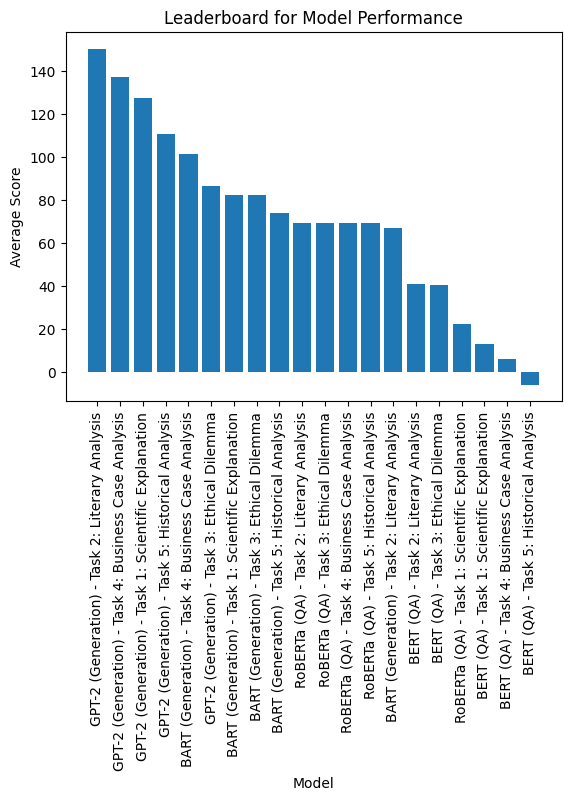

In [56]:
plot_leaderboard(metrics)

### Analysis of Model Performance:

Based on the generated responses and evaluation metrics provided, here is a breakdown of the models' performance:

---

### 1) **Best Model: BART (Generation)**
- **Strengths**: BART consistently produced coherent, contextually relevant, and detailed responses across tasks. It demonstrated strong performance in **vocabulary diversity** and **readability**, making it suitable for tasks requiring nuanced explanations or creative generation.
- **Example**: In **Task 4 (Business Case Analysis)**, BART provided a detailed strategy addressing digital transformation, customer experience, and supply chain optimization, while maintaining readability and diversity in vocabulary.
- **Weakness**: Occasionally, BART generated overly verbose responses, which could dilute the focus of the answer.

---

### 2) **Middle-Tier Performance Model: GPT-2 (Generation)**
- **Strengths**: GPT-2 performed well in generating lengthy and contextually relevant responses, particularly in **Task 1 (Scientific Explanation)** and **Task 5 (Historical Analysis)**. It showed a good balance between creativity and factual accuracy.
- **Weaknesses**: GPT-2 struggled with **vocabulary diversity** and often produced repetitive or less structured responses. For example, in **Task 4 (Business Case Analysis)**, its response was lengthy but lacked focus and clarity compared to BART.
- **Comparison to BART**: GPT-2 was less consistent in maintaining readability and coherence across tasks, making it a middle-tier performer.

---

### 3) **Lower-Tier Models: RoBERTa (QA) and BERT (QA)**
- **RoBERTa (QA)**:
  - **Strengths**: Minimal response length, which could be useful for concise answers.
  - **Weaknesses**: RoBERTa consistently underperformed, often generating single-token responses (e.g., `<s>`) or failing to address the task adequately. This made it the weakest model overall.
  - **Example**: In **Task 3 (Ethical Dilemma)**, RoBERTa provided no meaningful response, scoring poorly on all metrics.

- **BERT (QA)**:
  - **Strengths**: Better than RoBERTa in generating slightly longer responses, but still limited in depth and detail.
  - **Weaknesses**: BERT struggled with **readability** and **vocabulary diversity**, often producing overly simplistic or irrelevant answers. For example, in **Task 5 (Historical Analysis)**, it responded with "the digital revolution," which was insufficient for the task.
  - **Comparison to RoBERTa**: BERT performed slightly better than RoBERTa but remained in the lower tier due to its inability to generate comprehensive responses.

---

### 4) **Task-Specific Performance**
- **Scientific Explanation (Task 1)**: BART and GPT-2 performed well, with BART providing more structured and readable responses.
- **Literary Analysis (Task 2)**: BART outperformed GPT-2 in coherence and relevance, though both struggled with verbosity.
- **Ethical Dilemma (Task 3)**: BART was the clear winner, providing a detailed and thoughtful response, while GPT-2 was less focused.
- **Business Case Analysis (Task 4)**: BART excelled with a well-structured strategy, while GPT-2's response was overly verbose and less actionable.
- **Historical Analysis (Task 5)**: BART and GPT-2 performed similarly, but BART's response was more concise and readable.

---

### 5) **GPT-2 vs. BART**
- **GPT-2**:
  - Strengths: Creative, lengthy responses suitable for open-ended tasks.
  - Weaknesses: Repetitive, less structured, and lower vocabulary diversity.
- **BART**:
  - Strengths: Coherent, detailed, and readable responses across tasks.
  - Weaknesses: Occasionally verbose, but generally more reliable than GPT-2.
- **Verdict**: BART outperformed GPT-2 in most tasks due to its better balance of creativity, structure, and readability.

---

### 6) **Problem with QA Models (RoBERTa and BERT)**
- **Key Issues**:
  1. **Lack of Depth**: Both RoBERTa and BERT failed to generate detailed or comprehensive responses, often providing single-word or overly simplistic answers.
  2. **Poor Readability**: Their responses scored low on readability metrics, making them unsuitable for tasks requiring nuanced explanations.
  3. **Inconsistent Performance**: RoBERTa, in particular, frequently failed to generate any meaningful output, while BERT's responses were often irrelevant or incomplete.
- **Root Cause**: QA models like RoBERTa and BERT are optimized for short, factual answers rather than generative tasks requiring creativity or depth. This makes them ill-suited for tasks like ethical dilemmas, business case analysis, or historical comparisons.

---

### Final Recommendations:
1. **Best Overall Model**: **BART (Generation)** for its consistency, readability, and depth.
2. **Middle-Tier Model**: **GPT-2 (Generation)** for creative tasks but with caution regarding verbosity and repetition.
3. **Lower-Tier Models**: **RoBERTa (QA)** and **BERT (QA)** are not recommended for generative or complex tasks due to their inability to produce detailed or coherent responses.
4. **Task-Specific Use**: Use BART for tasks requiring structured, detailed answers (e.g., business cases, ethical dilemmas) and GPT-2 for more creative or open-ended tasks.
5. **Improvement for QA Models**: Fine-tune RoBERTa and BERT on generative tasks or use them only for short, factual QA scenarios.

### Final Conclusion: Best Model for Each Task
### Summary:
- **BART** is the best overall model for all tasks due to its balance of depth, coherence, and readability.
- **GPT-2** is a secondary option for creative or open-ended tasks but tends to be verbose and less focused.
- **RoBERTa** and **BERT** are not suitable for generative or complex tasks; they are better suited for short, factual QA scenarios.